<a href="https://colab.research.google.com/github/kfahn22/computer-vision-course/blob/synthetic-data-creation-lung-images/Synthetic_Date_Creation_lung_images_seed_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using DCGAN to Generate Synthetic Lung Images

* DCGAN was proposed in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) by Radford, et al.

In this notebook we will:

* Download lung Xray images from the Hugging Face Hub
* Prepocess the images
* Use DCGAN to generate synthetic images
* Visualize the training process

* This demo notebook has been adapted from [here](https://github.com/ovh/ai-training-examples/blob/main/notebooks/computer-vision/image-generation/miniconda/dcgan-image-generation/notebook_chest_image_generation_dcgan.ipynb) and [here](https://github.com/huggingface/community-events/tree/main/huggan/pytorch/dcgan).  

### About the Dataset

#### Summary taken from [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418301545%3Fshowall%3Dtrue):

* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

* Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

* For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

[Dataset Source](https://data.mendeley.com/datasets/rscbjbr9sj/2)

**Citation:**

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2


## Install the dependencies

In [1]:
!pip install -q datasets huggingface_hub datasets torch torchvision accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


### Log into Hugging Face Hub

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## Import the necessary libraries

In [3]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
import torchvision.utils as vutils
from torch.utils.data import DataLoader

## Load and preprocess the the dataset

In [4]:
# load the datset of lung images
dataset = load_dataset("hf-vision/chest-xray-pneumonia")

# Load 9 images
nb_images = 9
nb_row = math.ceil(math.sqrt(nb_images))

batch_size = 128
nb_gpu = 1
nb_workers = 2 # based on system resources

# GPU or CPU (Not having at least 1 GPU can prevent code from working)
device = torch.device("cuda:0" if (torch.cuda.is_available() and nb_gpu > 0) else "cpu")
n_channels = 3
image_size = 64
input_shape = (image_size, image_size)

transform=Compose(
    [
          transforms.Resize(image_size),
          transforms.CenterCrop(image_size),
          transforms.ToTensor(),
    ]
)

# define function
def transforms(examples):
   examples["image"] = [transform(image.convert("RGB")) for image in examples["image"]]
   return examples

transformed_dataset = dataset.with_transform(transforms)

#create dataloader
dataloader = DataLoader(
     transformed_dataset["train"], batch_size=batch_size, shuffle=True, num_workers=nb_workers
)

real_batch = next(iter(dataloader))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5216 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/624 [00:00<?, ? examples/s]

### Let's look at an image

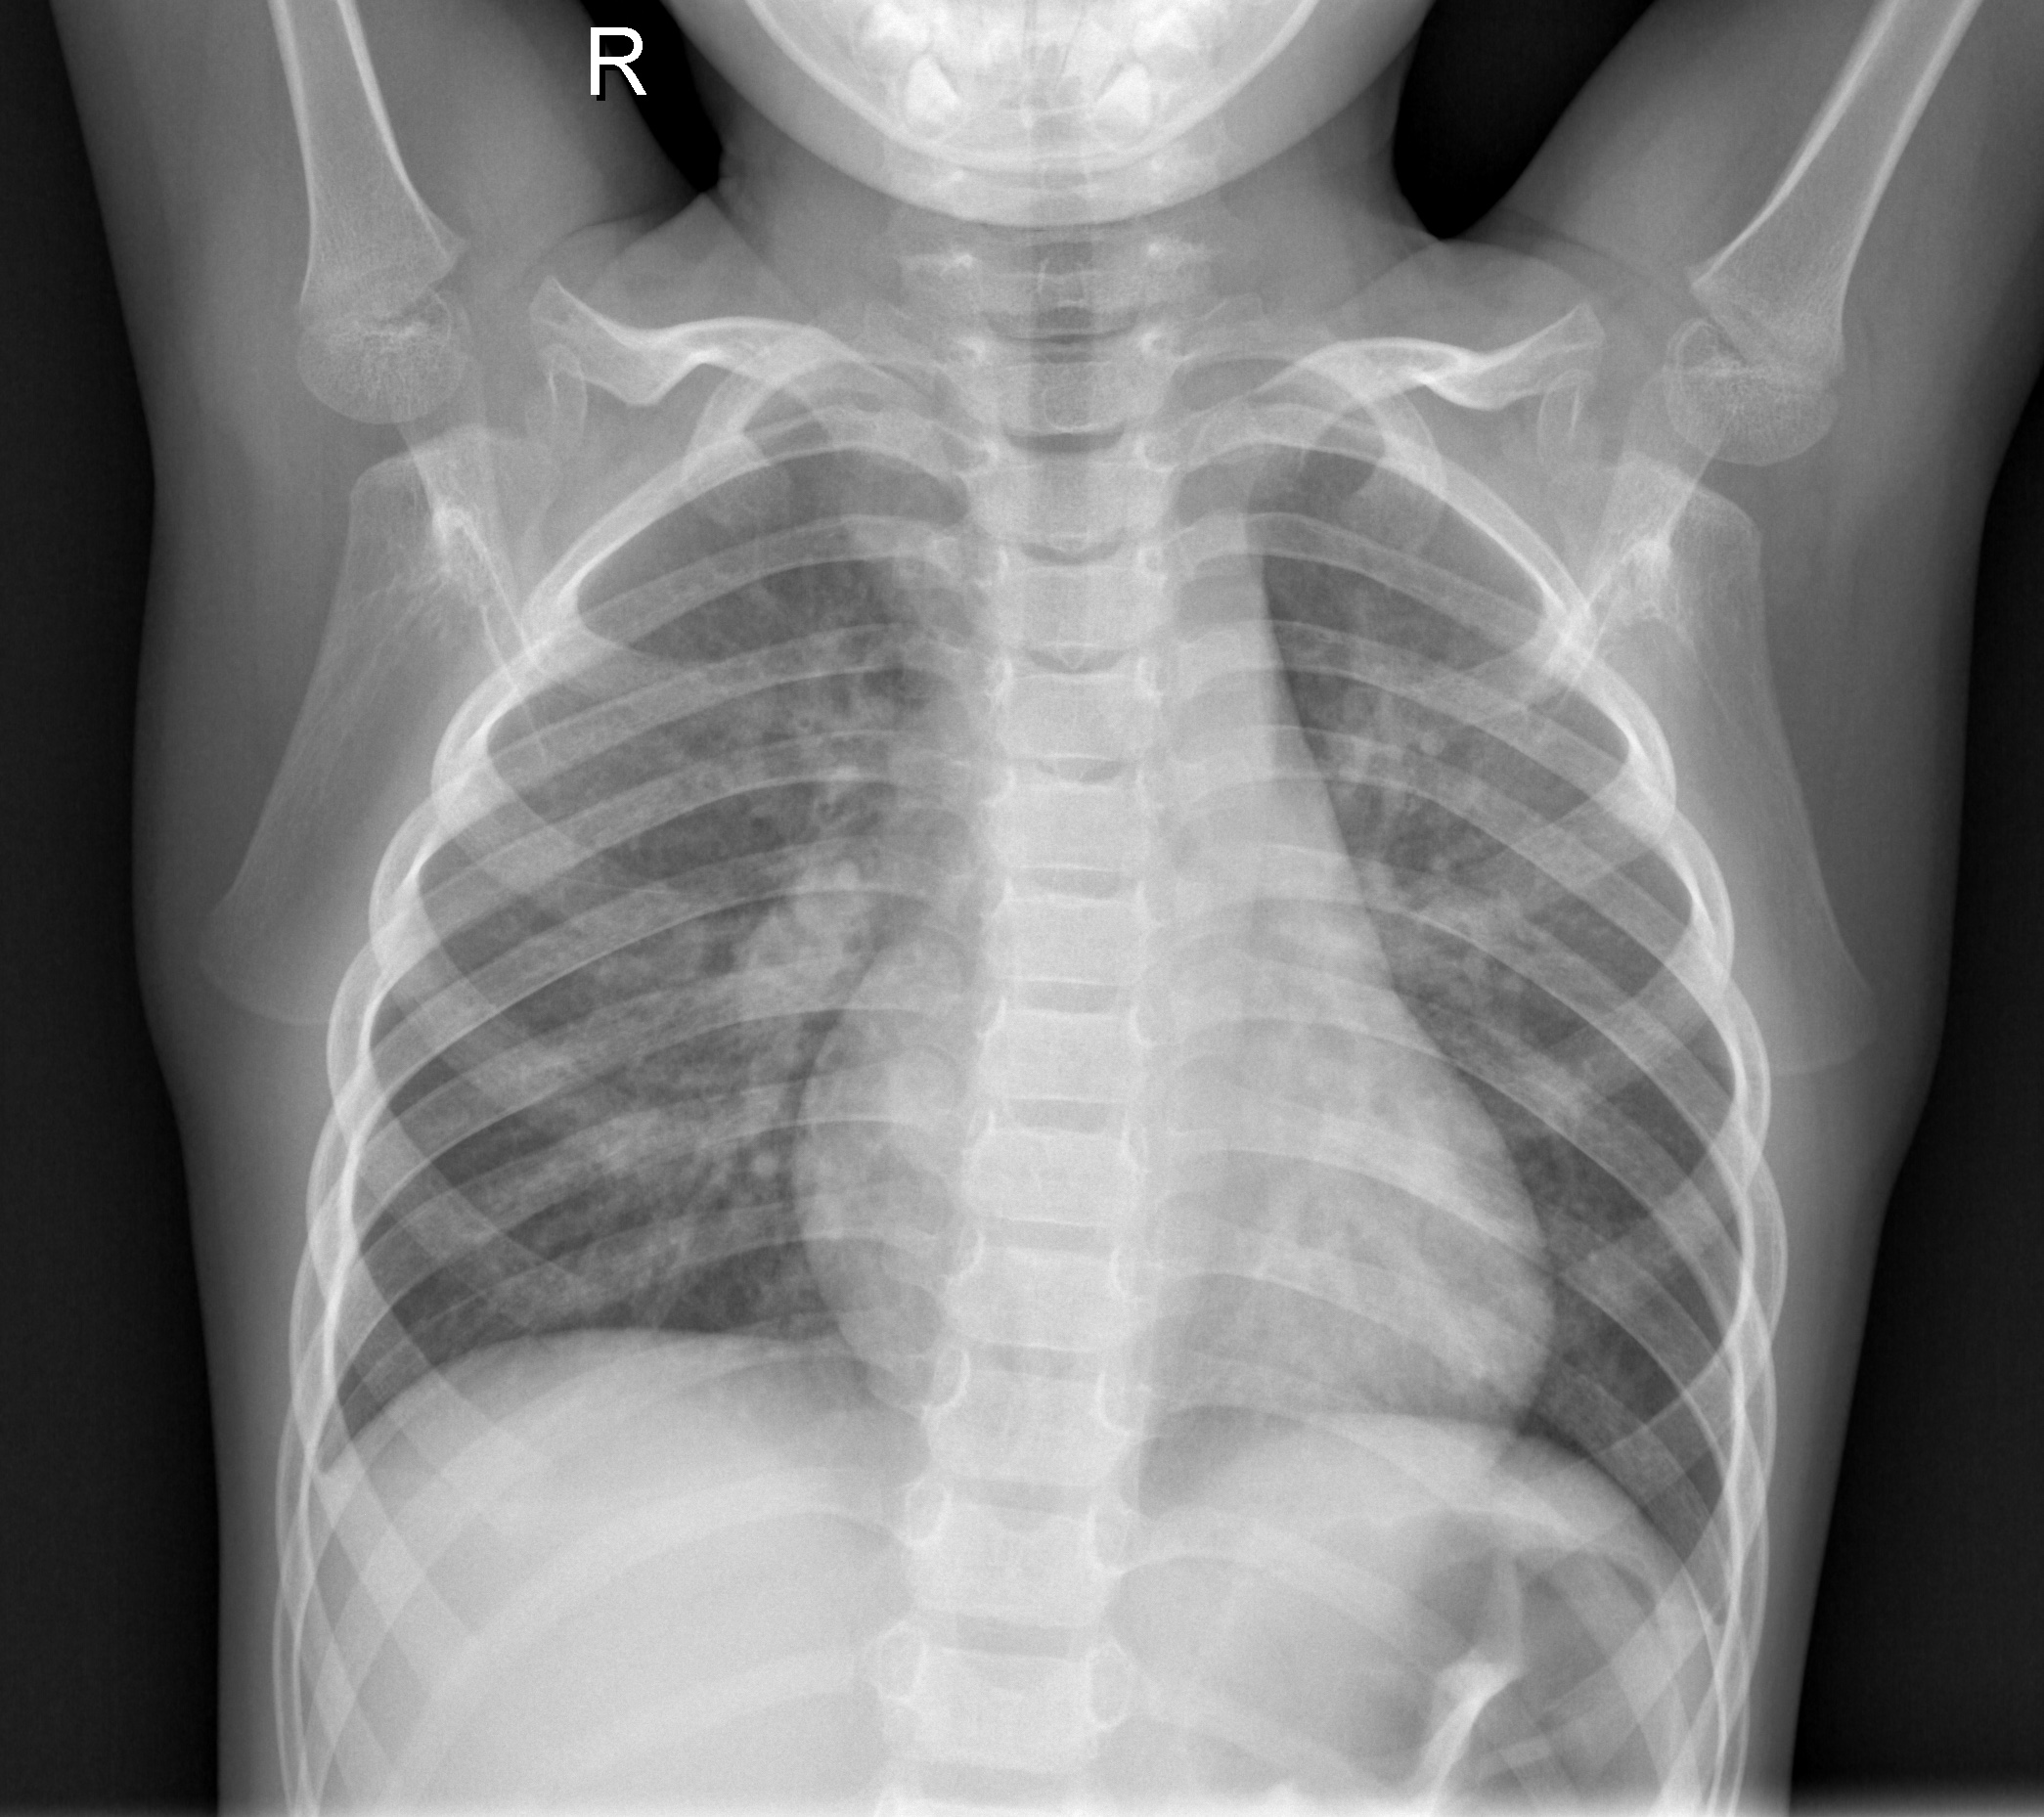

In [5]:
# Check a sample image.
dataset["train"][0]["image"]

### We will set a seed so that the generation is reproducible.

In [6]:
seed = 22
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Process the dataset

In [7]:
# GPU or CPU (Not having at least 1 GPU can prevent code from working)
device = torch.device("cuda:0" if (torch.cuda.is_available() and nb_gpu > 0) else "cpu")

# Models

First, we define some parameters.

In [8]:
# Size of z latent vector (i.e. size of generator input), same size as described in the DCGAN paper
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers, same value as described in the DCGAN paper
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers, same value as described in the DCGAN paper
beta1 = 0.5

The model weights are randomly initialized from a Normal distribution with mean=0, stdev=0.02.
 These are applied to each layer of Generator and Discriminator.

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Define the Generator

In [10]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, nb_gpu):
        super(Generator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution

            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``

            nn.ConvTranspose2d(ngf, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nb_channels) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

## Create the generator

In [11]:
# Create the generator
netG = Generator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    netG = nn.DataParallel(netG, list(range(nb_gpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Define the Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, nb_gpu):
        super(Discriminator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(
            # input is ``(nb_channels) x 64 x 64``

            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    netD = nn.DataParallel(netD, list(range(nb_gpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
# Real image and discriminator thinks it is real - Right decision
target = 1
output= 0.99

print(-(target * math.log(output) + (1-target)*math.log(1-output)))

# Real image and discriminator thinks it is fake - False decision
target = 1
output= 0.01

print(-(target * math.log(output) + (1-target)*math.log(1-output)))

# False image but discriminator thinks it is real - False decision
target = 0
output= 0.99

print(-(target * math.log(output) + (1-target)*math.log(1-output)))

0.01005033585350145
4.605170185988091
4.605170185988091


## We will use Binary Cross Entropy Loss as our loss function.

* BCELoss measures the difference between the predicted probabilities and the actual target values.


In [15]:
# Set real and fake label values (following GAN paper convention)
real_label = 1.
fake_label = 0.

# Define loss function
criterion = nn.BCELoss()

## Set up the Optimizers

In [16]:
# Setup optimizers for both G and D, according to the DCGAN paper
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

### We initialize with random noise.

In [17]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

## Save the model checkpoints

In [18]:
# Flags - For each epoch
show_images = True
save_images = True
save_model = True

def save_dcgan(netG, netD, path_checkpoint):
    checkpoint = {"g_model_state_dict": netG.state_dict(),
                "d_model_state_dict": netD.state_dict(),
                }

    torch.save(checkpoint, path_checkpoint)

def makedir(new_dir):
  if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Create folders
makedir("images")
makedir("models")

## Create the training loop

Epoch: 0/100 Batches: 0/41	Loss_D: 1.2471   Loss_G: 4.1429    D(x): 0.5718    D(G(z)): 0.4113 / 0.0228


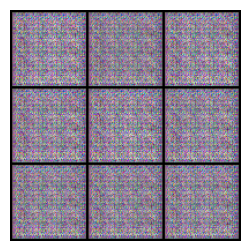

Epoch: 1/100 Batches: 0/41	Loss_D: 0.0276   Loss_G: 10.5466    D(x): 0.9978    D(G(z)): 0.0247 / 0.0000
Epoch: 2/100 Batches: 0/41	Loss_D: 0.4869   Loss_G: 7.5835    D(x): 0.7707    D(G(z)): 0.0003 / 0.0009
Epoch: 3/100 Batches: 0/41	Loss_D: 0.8923   Loss_G: 4.1953    D(x): 0.8717    D(G(z)): 0.4897 / 0.0204
Epoch: 4/100 Batches: 0/41	Loss_D: 0.3785   Loss_G: 2.0762    D(x): 0.8617    D(G(z)): 0.1830 / 0.1625
Epoch: 5/100 Batches: 0/41	Loss_D: 0.6935   Loss_G: 3.9772    D(x): 0.7711    D(G(z)): 0.2909 / 0.0299
Epoch: 6/100 Batches: 0/41	Loss_D: 1.2466   Loss_G: 5.4305    D(x): 0.9149    D(G(z)): 0.6410 / 0.0186
Epoch: 7/100 Batches: 0/41	Loss_D: 0.5519   Loss_G: 3.4034    D(x): 0.7505    D(G(z)): 0.1889 / 0.0452
Epoch: 8/100 Batches: 0/41	Loss_D: 0.9734   Loss_G: 5.6824    D(x): 0.8660    D(G(z)): 0.5119 / 0.0062
Epoch: 9/100 Batches: 0/41	Loss_D: 0.8296   Loss_G: 1.4409    D(x): 0.5445    D(G(z)): 0.0824 / 0.3142
Epoch: 10/100 Batches: 0/41	Loss_D: 0.6287   Loss_G: 3.2036    D(x): 0.6

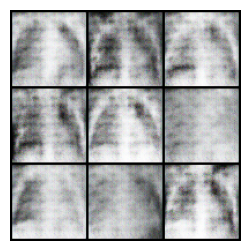

Epoch: 11/100 Batches: 0/41	Loss_D: 0.4874   Loss_G: 3.1277    D(x): 0.7951    D(G(z)): 0.1826 / 0.0641
Epoch: 12/100 Batches: 0/41	Loss_D: 0.3506   Loss_G: 3.1714    D(x): 0.8414    D(G(z)): 0.1307 / 0.0759
Epoch: 13/100 Batches: 0/41	Loss_D: 0.5827   Loss_G: 5.1596    D(x): 0.8686    D(G(z)): 0.3214 / 0.0112
Epoch: 14/100 Batches: 0/41	Loss_D: 0.3803   Loss_G: 3.0314    D(x): 0.8686    D(G(z)): 0.1786 / 0.0933
Epoch: 15/100 Batches: 0/41	Loss_D: 0.4874   Loss_G: 3.2036    D(x): 0.8194    D(G(z)): 0.2102 / 0.0652
Epoch: 16/100 Batches: 0/41	Loss_D: 0.8334   Loss_G: 6.9666    D(x): 0.9126    D(G(z)): 0.4609 / 0.0027
Epoch: 17/100 Batches: 0/41	Loss_D: 0.4879   Loss_G: 3.7890    D(x): 0.7625    D(G(z)): 0.1516 / 0.0385
Epoch: 18/100 Batches: 0/41	Loss_D: 0.7555   Loss_G: 6.6119    D(x): 0.9603    D(G(z)): 0.4424 / 0.0065
Epoch: 19/100 Batches: 0/41	Loss_D: 0.3823   Loss_G: 4.5118    D(x): 0.8086    D(G(z)): 0.1243 / 0.0206
Epoch: 20/100 Batches: 0/41	Loss_D: 1.2514   Loss_G: 4.4028    D

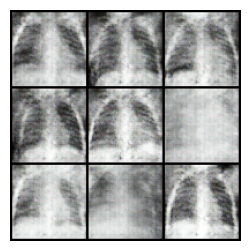

Epoch: 21/100 Batches: 0/41	Loss_D: 0.3889   Loss_G: 4.0678    D(x): 0.8403    D(G(z)): 0.1647 / 0.0385
Epoch: 22/100 Batches: 0/41	Loss_D: 0.6008   Loss_G: 4.1845    D(x): 0.6961    D(G(z)): 0.1032 / 0.0365
Epoch: 23/100 Batches: 0/41	Loss_D: 0.7030   Loss_G: 4.6924    D(x): 0.7771    D(G(z)): 0.2958 / 0.0349
Epoch: 24/100 Batches: 0/41	Loss_D: 0.6118   Loss_G: 5.0909    D(x): 0.8686    D(G(z)): 0.3386 / 0.0235
Epoch: 25/100 Batches: 0/41	Loss_D: 0.4660   Loss_G: 3.6529    D(x): 0.9213    D(G(z)): 0.2826 / 0.0476
Epoch: 26/100 Batches: 0/41	Loss_D: 0.6990   Loss_G: 5.8129    D(x): 0.8867    D(G(z)): 0.4014 / 0.0082
Epoch: 27/100 Batches: 0/41	Loss_D: 0.5707   Loss_G: 2.9458    D(x): 0.6998    D(G(z)): 0.1147 / 0.1017
Epoch: 28/100 Batches: 0/41	Loss_D: 0.4327   Loss_G: 3.5132    D(x): 0.8026    D(G(z)): 0.1453 / 0.0422
Epoch: 29/100 Batches: 0/41	Loss_D: 0.6367   Loss_G: 4.7538    D(x): 0.8444    D(G(z)): 0.3286 / 0.0178
Epoch: 30/100 Batches: 0/41	Loss_D: 1.1392   Loss_G: 1.8240    D

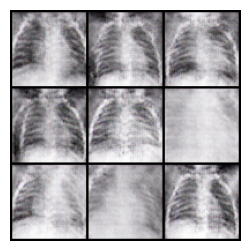

Epoch: 31/100 Batches: 0/41	Loss_D: 1.2504   Loss_G: 2.9675    D(x): 0.4515    D(G(z)): 0.0264 / 0.1831
Epoch: 32/100 Batches: 0/41	Loss_D: 0.5040   Loss_G: 4.0936    D(x): 0.8483    D(G(z)): 0.2596 / 0.0276
Epoch: 33/100 Batches: 0/41	Loss_D: 0.5751   Loss_G: 5.7622    D(x): 0.8489    D(G(z)): 0.2902 / 0.0114
Epoch: 34/100 Batches: 0/41	Loss_D: 0.7996   Loss_G: 6.1933    D(x): 0.8929    D(G(z)): 0.4387 / 0.0074
Epoch: 35/100 Batches: 0/41	Loss_D: 1.2526   Loss_G: 11.1946    D(x): 0.9548    D(G(z)): 0.6727 / 0.0003
Epoch: 36/100 Batches: 0/41	Loss_D: 0.6993   Loss_G: 6.1949    D(x): 0.9536    D(G(z)): 0.4329 / 0.0063
Epoch: 37/100 Batches: 0/41	Loss_D: 0.4766   Loss_G: 4.0137    D(x): 0.8150    D(G(z)): 0.1974 / 0.0299
Epoch: 38/100 Batches: 0/41	Loss_D: 0.5602   Loss_G: 5.1043    D(x): 0.8725    D(G(z)): 0.2892 / 0.0092
Epoch: 39/100 Batches: 0/41	Loss_D: 0.5470   Loss_G: 5.3374    D(x): 0.9353    D(G(z)): 0.3472 / 0.0093
Epoch: 40/100 Batches: 0/41	Loss_D: 0.3421   Loss_G: 5.0288    

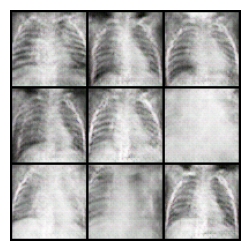

Epoch: 41/100 Batches: 0/41	Loss_D: 0.5326   Loss_G: 4.6725    D(x): 0.8627    D(G(z)): 0.2923 / 0.0214
Epoch: 42/100 Batches: 0/41	Loss_D: 0.2733   Loss_G: 3.4132    D(x): 0.9069    D(G(z)): 0.1366 / 0.0550
Epoch: 43/100 Batches: 0/41	Loss_D: 0.4901   Loss_G: 4.2468    D(x): 0.7939    D(G(z)): 0.1890 / 0.0246
Epoch: 44/100 Batches: 0/41	Loss_D: 0.3204   Loss_G: 4.8503    D(x): 0.9234    D(G(z)): 0.1996 / 0.0146
Epoch: 45/100 Batches: 0/41	Loss_D: 0.3707   Loss_G: 3.8417    D(x): 0.8418    D(G(z)): 0.1438 / 0.0366
Epoch: 46/100 Batches: 0/41	Loss_D: 0.3927   Loss_G: 3.0924    D(x): 0.7996    D(G(z)): 0.1156 / 0.0762
Epoch: 47/100 Batches: 0/41	Loss_D: 0.5056   Loss_G: 2.6329    D(x): 0.6914    D(G(z)): 0.0643 / 0.1314
Epoch: 48/100 Batches: 0/41	Loss_D: 1.0052   Loss_G: 9.4275    D(x): 0.9480    D(G(z)): 0.5492 / 0.0014
Epoch: 49/100 Batches: 0/41	Loss_D: 0.3161   Loss_G: 3.7401    D(x): 0.8893    D(G(z)): 0.1620 / 0.0378
Epoch: 50/100 Batches: 0/41	Loss_D: 0.2792   Loss_G: 4.1678    D

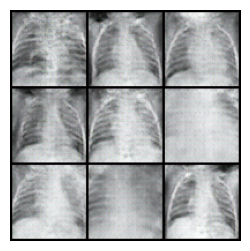

Epoch: 51/100 Batches: 0/41	Loss_D: 0.4307   Loss_G: 4.2538    D(x): 0.8504    D(G(z)): 0.2025 / 0.0232
Epoch: 52/100 Batches: 0/41	Loss_D: 1.0859   Loss_G: 4.1833    D(x): 0.4377    D(G(z)): 0.0059 / 0.0526
Epoch: 53/100 Batches: 0/41	Loss_D: 0.4142   Loss_G: 3.2863    D(x): 0.8049    D(G(z)): 0.1528 / 0.0554
Epoch: 54/100 Batches: 0/41	Loss_D: 1.0829   Loss_G: 9.3177    D(x): 0.9591    D(G(z)): 0.5812 / 0.0022
Epoch: 55/100 Batches: 0/41	Loss_D: 0.6115   Loss_G: 7.2693    D(x): 0.9514    D(G(z)): 0.4046 / 0.0053
Epoch: 56/100 Batches: 0/41	Loss_D: 0.2988   Loss_G: 3.2849    D(x): 0.8559    D(G(z)): 0.1075 / 0.0561
Epoch: 57/100 Batches: 0/41	Loss_D: 0.2884   Loss_G: 3.1473    D(x): 0.8417    D(G(z)): 0.0844 / 0.0835
Epoch: 58/100 Batches: 0/41	Loss_D: 0.4667   Loss_G: 2.9856    D(x): 0.7205    D(G(z)): 0.0514 / 0.0815
Epoch: 59/100 Batches: 0/41	Loss_D: 0.2497   Loss_G: 3.9362    D(x): 0.9032    D(G(z)): 0.1229 / 0.0295
Epoch: 60/100 Batches: 0/41	Loss_D: 0.3314   Loss_G: 3.5485    D

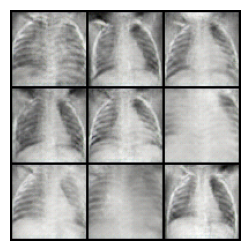

Epoch: 61/100 Batches: 0/41	Loss_D: 0.3771   Loss_G: 3.3151    D(x): 0.8458    D(G(z)): 0.1545 / 0.0745
Epoch: 62/100 Batches: 0/41	Loss_D: 0.6037   Loss_G: 2.3972    D(x): 0.6787    D(G(z)): 0.0634 / 0.1706
Epoch: 63/100 Batches: 0/41	Loss_D: 0.5035   Loss_G: 3.7641    D(x): 0.7872    D(G(z)): 0.1867 / 0.0394
Epoch: 64/100 Batches: 0/41	Loss_D: 0.3989   Loss_G: 3.9563    D(x): 0.8600    D(G(z)): 0.1753 / 0.0371
Epoch: 65/100 Batches: 0/41	Loss_D: 0.4958   Loss_G: 5.6749    D(x): 0.8900    D(G(z)): 0.2821 / 0.0156
Epoch: 66/100 Batches: 0/41	Loss_D: 0.3135   Loss_G: 3.7851    D(x): 0.8759    D(G(z)): 0.1388 / 0.0420
Epoch: 67/100 Batches: 0/41	Loss_D: 0.2583   Loss_G: 4.0055    D(x): 0.8479    D(G(z)): 0.0670 / 0.0335
Epoch: 68/100 Batches: 0/41	Loss_D: 0.2593   Loss_G: 3.6003    D(x): 0.9546    D(G(z)): 0.1747 / 0.0403
Epoch: 69/100 Batches: 0/41	Loss_D: 0.2916   Loss_G: 3.1309    D(x): 0.8475    D(G(z)): 0.0948 / 0.0629
Epoch: 70/100 Batches: 0/41	Loss_D: 0.3856   Loss_G: 4.4345    D

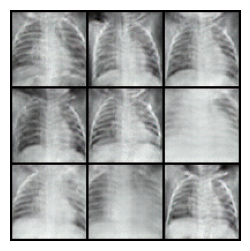

Epoch: 71/100 Batches: 0/41	Loss_D: 0.3571   Loss_G: 3.6968    D(x): 0.8469    D(G(z)): 0.1291 / 0.0516
Epoch: 72/100 Batches: 0/41	Loss_D: 0.5776   Loss_G: 2.0210    D(x): 0.6508    D(G(z)): 0.0330 / 0.1996
Epoch: 73/100 Batches: 0/41	Loss_D: 0.5350   Loss_G: 6.9103    D(x): 0.9669    D(G(z)): 0.3592 / 0.0042
Epoch: 74/100 Batches: 0/41	Loss_D: 0.5207   Loss_G: 3.4774    D(x): 0.6763    D(G(z)): 0.0181 / 0.0612
Epoch: 75/100 Batches: 0/41	Loss_D: 0.3475   Loss_G: 4.6209    D(x): 0.8963    D(G(z)): 0.1878 / 0.0209
Epoch: 76/100 Batches: 0/41	Loss_D: 0.3535   Loss_G: 4.4632    D(x): 0.8929    D(G(z)): 0.1810 / 0.0203
Epoch: 77/100 Batches: 0/41	Loss_D: 0.2195   Loss_G: 5.0663    D(x): 0.9391    D(G(z)): 0.1308 / 0.0119
Epoch: 78/100 Batches: 0/41	Loss_D: 0.7973   Loss_G: 8.3836    D(x): 0.9584    D(G(z)): 0.4898 / 0.0009
Epoch: 79/100 Batches: 0/41	Loss_D: 0.6403   Loss_G: 2.2829    D(x): 0.6506    D(G(z)): 0.0778 / 0.1423
Epoch: 80/100 Batches: 0/41	Loss_D: 0.2870   Loss_G: 3.7374    D

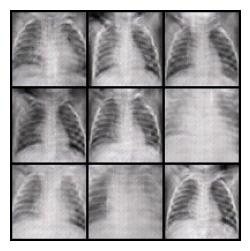

Epoch: 81/100 Batches: 0/41	Loss_D: 0.2002   Loss_G: 5.1425    D(x): 0.9262    D(G(z)): 0.1039 / 0.0135
Epoch: 82/100 Batches: 0/41	Loss_D: 0.3357   Loss_G: 4.8378    D(x): 0.8923    D(G(z)): 0.1629 / 0.0271
Epoch: 83/100 Batches: 0/41	Loss_D: 0.2279   Loss_G: 3.9899    D(x): 0.8448    D(G(z)): 0.0304 / 0.0271
Epoch: 84/100 Batches: 0/41	Loss_D: 0.3205   Loss_G: 3.6868    D(x): 0.8578    D(G(z)): 0.1281 / 0.0409
Epoch: 85/100 Batches: 0/41	Loss_D: 0.2192   Loss_G: 4.8640    D(x): 0.9519    D(G(z)): 0.1419 / 0.0131
Epoch: 86/100 Batches: 0/41	Loss_D: 0.2453   Loss_G: 4.8408    D(x): 0.8434    D(G(z)): 0.0449 / 0.0129
Epoch: 87/100 Batches: 0/41	Loss_D: 0.2874   Loss_G: 4.8611    D(x): 0.9268    D(G(z)): 0.1653 / 0.0176
Epoch: 88/100 Batches: 0/41	Loss_D: 0.2319   Loss_G: 3.6758    D(x): 0.8831    D(G(z)): 0.0880 / 0.0357
Epoch: 89/100 Batches: 0/41	Loss_D: 0.5605   Loss_G: 7.4214    D(x): 0.9696    D(G(z)): 0.3661 / 0.0040
Epoch: 90/100 Batches: 0/41	Loss_D: 0.2026   Loss_G: 4.6599    D

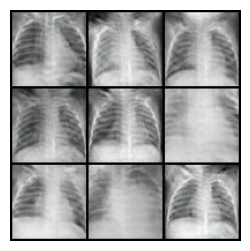

Epoch: 91/100 Batches: 0/41	Loss_D: 0.3077   Loss_G: 3.6690    D(x): 0.8828    D(G(z)): 0.1299 / 0.0378
Epoch: 92/100 Batches: 0/41	Loss_D: 0.2029   Loss_G: 5.3057    D(x): 0.9599    D(G(z)): 0.1380 / 0.0086
Epoch: 93/100 Batches: 0/41	Loss_D: 0.2226   Loss_G: 3.7122    D(x): 0.8538    D(G(z)): 0.0428 / 0.0357
Epoch: 94/100 Batches: 0/41	Loss_D: 0.2779   Loss_G: 5.6854    D(x): 0.9800    D(G(z)): 0.2107 / 0.0055
Epoch: 95/100 Batches: 0/41	Loss_D: 0.2958   Loss_G: 4.9717    D(x): 0.8130    D(G(z)): 0.0279 / 0.0169
Epoch: 96/100 Batches: 0/41	Loss_D: 0.2075   Loss_G: 5.3957    D(x): 0.8801    D(G(z)): 0.0495 / 0.0157
Epoch: 97/100 Batches: 0/41	Loss_D: 1.0149   Loss_G: 8.3415    D(x): 0.9922    D(G(z)): 0.4592 / 0.0023
Epoch: 98/100 Batches: 0/41	Loss_D: 0.4781   Loss_G: 8.3275    D(x): 0.9519    D(G(z)): 0.3064 / 0.0009
Epoch: 99/100 Batches: 0/41	Loss_D: 0.2608   Loss_G: 4.0174    D(x): 0.8205    D(G(z)): 0.0249 / 0.0357


In [19]:
# Training Loop
data_len = len(dataloader)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []


# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader (depends on batch_size and your number of images)
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data['image'].to(device)
        #real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        ############################
        # (3) Metrics & Evaluation
        ###########################

        # Print output training stats every 50 batches (if your dataset is large, printing at every epoch might be less frequent than you want)
        if i % 50 == 0:
            print(f"Epoch: {epoch}/{num_epochs} Batches: {i}/{data_len}\tLoss_D: {errD.item():.4f}   Loss_G: {errG.item():.4f}    D(x): {D_x:.4f}    D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # Generate fake images to see how the generator is doing by saving G's output on fixed_noise at each epoch (fixed noise allow to obtain similar images).
    if show_images == True and epoch % 10 == 0:
        with torch.no_grad():
            # Uncomment the line below to generate a new variety of images every time
            #fixed_noise = torch.randn(64, nz, 1, 1, device=device)

            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake[:nb_images], padding=2, normalize=True, nrow=nb_row))

            plt.figure(figsize=(3, 3))
            plt.axis("off")
            plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

            if save_images == True:
                plt.savefig(f'images/epoch_{epoch}_gen_images.png')

            # Display image
            plt.show()

    # Save models each 5 epochs
    if epoch % 5 == 0:
        if save_model:
            save_dcgan(netG, netD, path_checkpoint=f"models/chest_epoch_{epoch}_checkpoint.pkl")

# Save the final models
save_dcgan(netG, netD, path_checkpoint="models/chest_final_epoch_checkpoint.pkl")

In [20]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt

## Plot losses

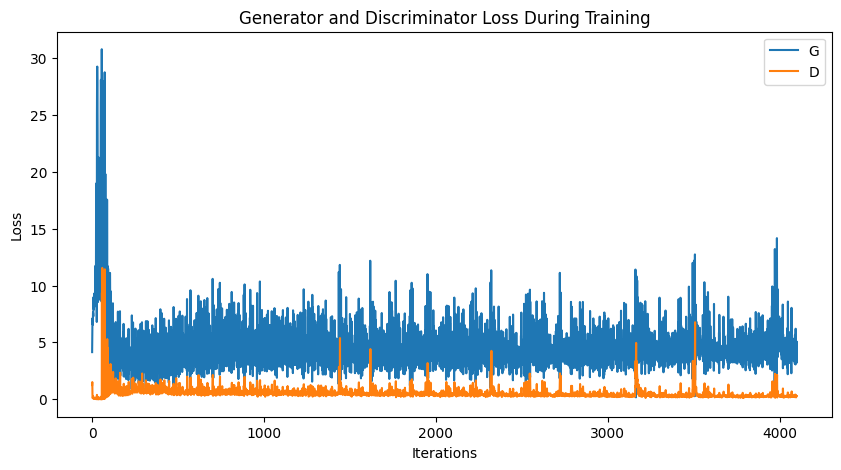

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
# increase the default limit set by Matplotlib for embedding animations
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 100  # 100 MB

## Follow the training

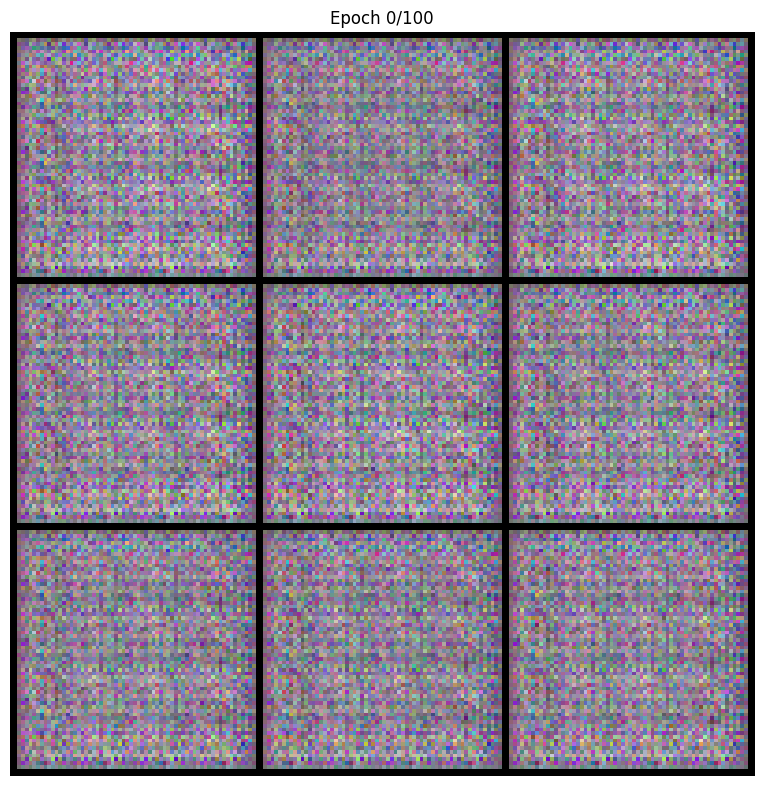

In [23]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

# Initial empty title and image
title = plt.title("")
img_plot = plt.imshow(np.transpose(img_list[0], (1, 2, 0)), animated=True)

def update_title_and_image(frame):
    img_plot.set_array(np.transpose(img_list[frame], (1, 2, 0)))
    title.set_text(f"Epoch {frame}/{num_epochs}")

ani = animation.FuncAnimation(fig, update_title_and_image, frames=len(img_list), interval=100, repeat_delay=5000)

# Display animation
HTML(ani.to_jshtml())

In [24]:
# Save the animation as a GIF
ani.save('images/dcgan_training_animation.gif', writer='pillow')

## Inference

In [25]:
# Specify desired weights path
path_checkpoint = "models/chest_final_epoch_checkpoint.pkl"

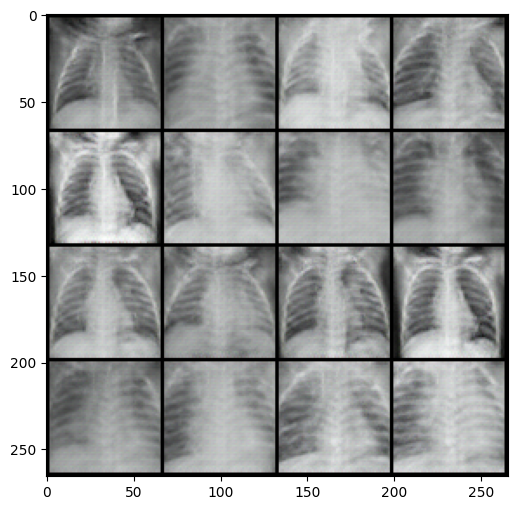

In [26]:
# Number of desired images
num_img = 16
nb_row = math.ceil(math.sqrt(num_img))

# Create a random noise
random_noise = torch.randn(num_img, nz, 1, 1, device=device)

# Instantiate a generator
new_gen= Generator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    new_gen = nn.DataParallel(new_gen, list(range(nb_gpu)))

# Load weights from path
checkpoint = torch.load(path_checkpoint, map_location="cpu")
state_dict_g = checkpoint["g_model_state_dict"]
new_gen.load_state_dict(state_dict_g)

# Generate images
with torch.no_grad():
    fake_data = new_gen(random_noise).detach().cpu()

# Plot images
img_grid = vutils.make_grid(fake_data, padding=2, normalize=True, nrow=nb_row).cpu()
img_grid = np.transpose(img_grid, (1, 2, 0))
plt.figure(figsize=(6, 6))
plt.imshow(img_grid)
plt.show()

## Post Processing

In [27]:
# Instantiate a discriminator
new_dis= Discriminator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    new_dis = nn.DataParallel(new_dis, list(range(nb_gpu)))

# Load weights from path
checkpoint = torch.load(path_checkpoint, map_location="cpu")
state_dict_d = checkpoint["d_model_state_dict"]
new_dis.load_state_dict(state_dict_d)

<All keys matched successfully>

## Find verified images

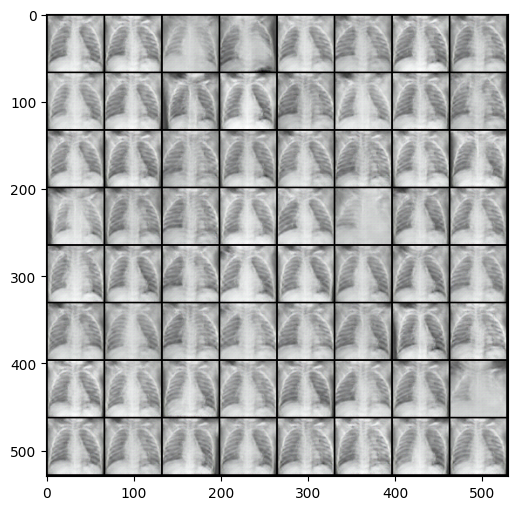

In [29]:
# Set threshold
threshold = 0.70


# Create list to store the images classified as >= threshold
verified_images = []

# Till we do not have 64 images

while len(verified_images)<64:
    # Create a random noise
    random_noise = torch.randn(num_img, nz, 1, 1, device=device)
    # Generate images for this noise
    with torch.no_grad():
        fake_data = new_gen(random_noise)

        # Set the discriminator to eval mode
        new_dis.eval()

        # Pass the generated fake_data through the discriminator & obtain real/fake probabilities
        output_probabilities = new_dis(fake_data)

    # Create mask (If prob < threshold, set to False, else True)
    good_image_mask = output_probabilities >= threshold

    # Remove extra tensor dims (torch.Size([16, 1, 1, 1]) -> torch.Size([16]))
    good_image_mask = good_image_mask.squeeze()

    # Keep the selected images
    good_images = fake_data[good_image_mask > threshold]

    # If good_images is not None
    if good_images.numel() > 0:
        # Loop through the tensor along the first dimension (index 0), since we have x images in a torch.Size([x, 3, 64, 64]) object
        for i in range(good_images.size(0)):
            # Add selected images
            verified_images.append(good_images[i])

# Plot selected images
img_grid = vutils.make_grid(verified_images, padding=2, normalize=True, nrow=8).cpu()
img_grid = np.transpose(img_grid, (1, 2, 0))
plt.figure(figsize=(6, 6))
plt.imshow(img_grid)
plt.show()